### Paritial dependence plots

An example of the partial dependence plots. For more information, please refer to https://scikit-learn.org/stable/modules/partial_dependence.html.

In [1]:
# This default renderer is used for sphinx docs only. Please delete this cell in IPython.
import plotly.io as pio
pio.renderers.default = "png"

In [2]:
import os
import sklearn
import xgboost
import numpy as np
import pandas as pd
from omnixai.data.tabular import Tabular
from omnixai.preprocessing.tabular import TabularTransform
from omnixai.explainers.tabular import PartialDependenceTabular

The dataset used in this example is for income prediction (https://archive.ics.uci.edu/ml/datasets/adult). We recommend using `Tabular` to represent a tabular dataset, which can be constructed from a pandas dataframe or a numpy array. To create a `Tabular` instance given a numpy array, one needs to specify the data, the feature names, the categorical feature names (if exists) and the target/label column name (if exists).

In [3]:
feature_names = [
    "Age", "Workclass", "fnlwgt", "Education",
    "Education-Num", "Marital Status", "Occupation",
    "Relationship", "Race", "Sex", "Capital Gain",
    "Capital Loss", "Hours per week", "Country", "label"
]
data = np.genfromtxt(os.path.join('../data', 'adult.data'), delimiter=', ', dtype=str)
tabular_data = Tabular(
    data,
    feature_columns=feature_names,
    categorical_columns=[feature_names[i] for i in [1, 3, 5, 6, 7, 8, 9, 13]],
    target_column='label'
)

`TabularTransform` is a special transform designed for tabular data. By default, it converts categorical features into one-hot encoding, and keeps continuous-valued features (if one wants to normalize continuous-valued features, set the parameter `cont_transform` in `TabularTransform` to `Standard` or `MinMax`). The `transform` method of `TabularTransform` will transform a `Tabular` instance into a numpy array. If the `Tabular` instance has a target/label column, the last column of the transformed numpy array will be the target/label. 

If one wants some other transformations that are not supported in the library, one can simply convert the `Tabular` instance into a pandas dataframe by calling `Tabular.to_pd()` and try different transformations with it.

After data preprocessing, we can train a XGBoost classifier for this task (one may try other classifiers). 

In [4]:
np.random.seed(1)
transformer = TabularTransform().fit(tabular_data)
class_names = transformer.class_names
x = transformer.transform(tabular_data)
train, test, labels_train, labels_test = \
    sklearn.model_selection.train_test_split(x[:, :-1], x[:, -1], train_size=0.80)
print('Training data shape: {}'.format(train.shape))
print('Test data shape:     {}'.format(test.shape))

gbtree = xgboost.XGBClassifier(n_estimators=300, max_depth=5)
gbtree.fit(train, labels_train)
print('Test accuracy: {}'.format(
    sklearn.metrics.accuracy_score(labels_test, gbtree.predict(test))))

Training data shape: (26048, 108)
Test data shape:     (6513, 108)
Test accuracy: 0.8668816213726394


The prediction function takes a `Tabular` instance as its inputs, and outputs the class probabilities for classification tasks or the estimated values for regression tasks. In this example, we simply call `transformer.transform` to do data preprocessing followed by the prediction function of `gbtree`.

In [5]:
predict_function=lambda z: gbtree.predict_proba(transformer.transform(z))

To initialize a PDO explainer, we need to set:
  
  - `training_data`: The data used to initialize a PDP explainer. ``training_data`` can be the training dataset for training the machine learning model. If the training dataset is too large, ``training_data`` can be a subset of it by applying `omnixai.sampler.tabular.Sampler.subsample`.
  - `predict_function`: The prediction function corresponding to the model.
  - `mode`: The task type, e.g., "classification" or "regression".

In [6]:
explainer = PartialDependenceTabular(
    training_data=tabular_data,
    predict_function=predict_function
)

PDP generates global explanations by calling `explainer.explain`. `ipython_plot` shows the generated explanations in IPython.

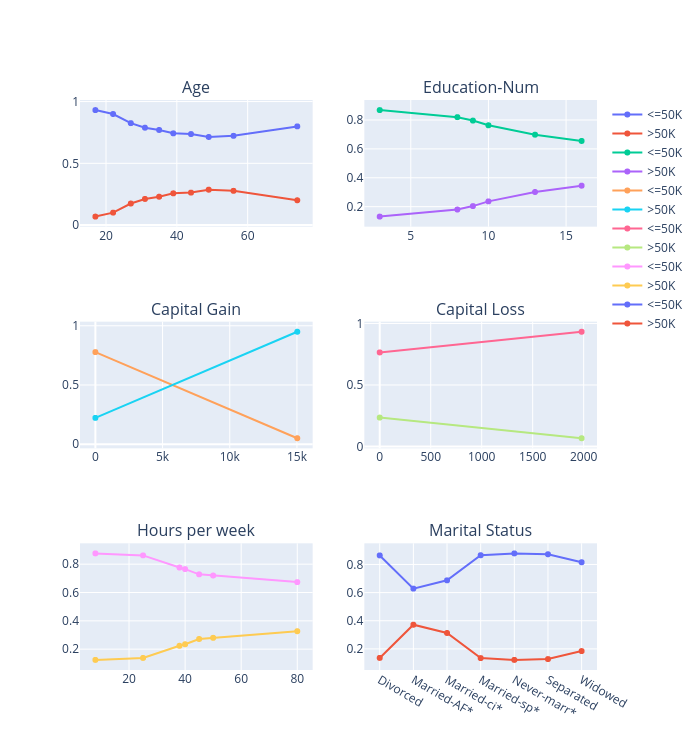

In [7]:
explanations = explainer.explain(
    features=["Age", "Education-Num", "Capital Gain","Capital Loss", "Hours per week", "Marital Status"])
explanations.ipython_plot(class_names=class_names)